In [9]:
import fastf1
from fastf1 import plotting
from fastf1.core import Laps
import matplotlib.pyplot as plt

from typing import Iterable, List, Optional
import warnings
import pandas as pd
import numpy as np
import requests
from scipy.signal import find_peaks
import io


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']


Index(['Date', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source',
       'Time', 'SessionTime', 'Distance'],
      dtype='object')


/Users/leoqian/CDS/F1ML2/venv/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


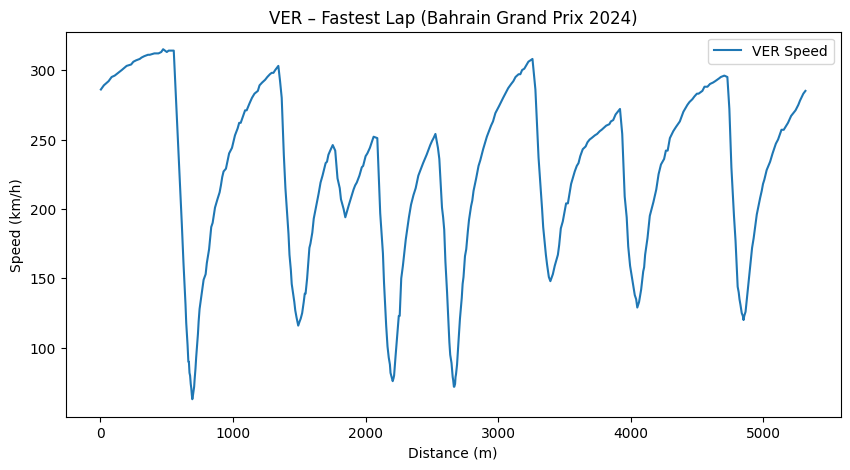

In [10]:
# 1. Load a session
session = fastf1.get_session(2024, 'Bahrain', 'FP1')
session.load()

# 2. Select a driver and lap
driver = 'VER'  # Max Verstappen's 3-letter code
laps = session.laps.pick_driver(driver)

# Choose the fastest lap
fastest_lap = laps.pick_fastest()

# 3. Get telemetry for that lap
telemetry = fastest_lap.get_car_data().add_distance()  # adds 'Distance' column

# Inspect columns
print(telemetry.columns)
# ['Time', 'RPM', 'Speed', 'Throttle', 'Brake', 'nGear', 'DRS', 'Source', 'Distance']

# 4. Plot speed vs distance
plt.figure(figsize=(10, 5))
plt.plot(telemetry['Distance'], telemetry['Speed'], label=f'{driver} Speed')
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.title(f'{driver} – Fastest Lap ({session.event.EventName} {session.event.year})')
plt.legend()
plt.show()


In [11]:
print(telemetry)

                       Date      RPM  Speed  nGear  Throttle  Brake  DRS  \
0   2024-02-29 12:08:53.621  11274.0  286.0      7     100.0  False   12   
1   2024-02-29 12:08:53.901  11407.0  289.0      7     100.0  False   12   
2   2024-02-29 12:08:54.341  11560.0  292.0      7     100.0  False   12   
3   2024-02-29 12:08:54.621  11131.0  295.0      7     100.0  False   12   
4   2024-02-29 12:08:54.901  10595.0  296.0      8     100.0  False   12   
..                      ...      ...    ...    ...       ...    ...  ...   
340 2024-02-29 12:10:25.542  10829.0  271.0      7     100.0  False   12   
341 2024-02-29 12:10:25.822  10996.0  275.0      7     100.0  False   12   
342 2024-02-29 12:10:25.982  11088.0  278.0      7     100.0  False   12   
343 2024-02-29 12:10:26.301  11202.0  283.0      7     100.0  False   12   
344 2024-02-29 12:10:26.501  11268.0  285.0      7     100.0  False   12   

    Source                   Time            SessionTime     Distance  
0      car 0 da

In [13]:
def collect_driver_telemetry(
    year: int,
    grand_prix: str,
    driver: str,
    sessions: Optional[Iterable[str]] = None,
    include_position: bool = False,
    cache_dir: str = "f1_cache",
) -> pd.DataFrame:
    # Enable on-disk cache (recommended to avoid re-downloading)
    #fastf1.Cache.enable_cache(cache_dir)

    # Reasonable default session list (FastF1 session identifiers)
    if sessions is None:
        sessions = ("FP1", "FP2", "FP3", "Q", "SQ", "SS", "S", "R")

    all_chunks: List[pd.DataFrame] = []

    for sess_name in sessions:
        # Load session (skip if not available for this event/year)
        try:
            session = fastf1.get_session(year, grand_prix, sess_name)
            session.load()
        except Exception as e:
            # Non-existent sessions (e.g., no Sprint) will land here—skip quietly
            warnings.warn(f"Skipping session {sess_name}: {e}")
            continue

        # Filter laps for the driver
        laps = session.laps.pick_driver(driver)
        if laps.empty:
            # Driver may not have participated in this session
            continue

        # Iterate laps and collect per-sample telemetry
        for _, lap in laps.iterlaps():
            try:
                car = lap.get_car_data().add_distance()  # Time, Speed, Throttle, Brake, RPM, nGear, DRS, Source, Distance
                # Add lap-level metadata as columns (broadcast)
                car["Year"] = year
                car["EventName"] = session.event.EventName
                car["SessionName"] = session.name
                car["Driver"] = driver
                car["LapNumber"] = int(lap["LapNumber"])
                # Optional lap attributes (may be NaN for some samples)
                for col in ["Stint", "Compound", "TyreLife", "IsAccurate", "PitInTime", "PitOutTime", "TrackStatus", "LapTime"]:
                    if col in laps.columns:
                        car[col] = lap.get(col, pd.NA)

                if include_position:
                    # Merge position data (X, Y, Z) with car telemetry on Time using merge_asof
                    pos = lap.get_pos_data().sort_values("Time").reset_index(drop=True)
                    car = car.sort_values("Time").reset_index(drop=True)
                    car = pd.merge_asof(
                        car,
                        pos[["Time", "X", "Y", "Z"]],
                        on="Time",
                        direction="nearest",
                        tolerance=pd.Timedelta("50ms"),  # tune if needed
                    )

                all_chunks.append(car)
            except Exception as e:
                warnings.warn(f"Failed telemetry for {driver} lap {int(lap['LapNumber'])} in {session.name}: {e}")
                continue

    if not all_chunks:
        return pd.DataFrame()  # nothing found

    df = pd.concat(all_chunks, ignore_index=True)

    # Nice column ordering (if present)
    preferred_order = [

        "Year", "EventName", "SessionName", "Driver", "LapNumber",
        "Stint", "Compound", "TyreLife", "IsAccurate", "PitInTime", "PitOutTime", "TrackStatus", "LapTime",
        "Time", "Distance", "Speed", "Throttle", "Brake", "nGear", "RPM", "DRS", "Source",
        "X", "Y", "Z"
    ]
    cols = [c for c in preferred_order if c in df.columns] + [c for c in df.columns if c not in preferred_order]
    df = df[cols]

    return df

In [14]:
df_xy = collect_driver_telemetry(2024, "Bahrain", "VER","R", include_position=True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
/Users/leoqian/CDS/F1ML2/venv/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be re

In [16]:
df_xy

,Year,EventName,SessionName,Driver,LapNumber,Stint,Compound,TyreLife,IsAccurate,PitInTime,...,Brake,nGear,RPM,DRS,Source,X,Y,Z,Date,SessionTime
0,2024,Bahrain Grand Prix,Race,VER,1,1.0,SOFT,4.0,False,NaT,...,True,1,9963.0,1,car,NaN,NaN,NaN,2024-03-02 15:03:42.390,0 days 00:59:59.959000
1,2024,Bahrain Grand Prix,Race,VER,1,1.0,SOFT,4.0,False,NaT,...,True,1,9755.0,1,car,NaN,NaN,NaN,2024-03-02 15:03:42.630,0 days 01:00:00.199000
2,2024,Bahrain Grand Prix,Race,VER,1,1.0,SOFT,4.0,False,NaT,...,False,1,8495.0,1,car,NaN,NaN,NaN,2024-03-02 15:03:42.870,0 days 01:00:00.439000
3,2024,Bahrain Grand Prix,Race,VER,1,1.0,SOFT,4.0,False,NaT,...,False,1,6815.0,1,car,NaN,NaN,NaN,2024-03-02 15:03:43.110,0 days 01:00:00.679000
4,2024,Bahrain Grand Prix,Race,VER,1,1.0,SOFT,4.0,False,NaT,...,False,1,5695.0,1,car,NaN,NaN,NaN,2024-03-02 15:03:43.270,0 days 01:00:00.839000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20521,2024,Bahrain Grand Prix,Race,VER,57,3.0,SOFT,20.0,True,NaT,...,False,7,10858.0,0,car,-423.0,436.0,-159.0,2024-03-02 16:35:26.166,0 days 02:31:43.735000
20522,2024,Bahrain Grand Prix,Race,VER,57,3.0,SOFT,20.0,True,NaT,...,False,7,10896.0,0,car,NaN,NaN,NaN,2024-03-02 16:35:26.406,0 days 02:31:43.975000
20523,2024,Bahrain Grand Prix,Race,VER,57,3.0,SOFT,20.0,True,NaT,...,False,7,10918.0,0,car,NaN,NaN,NaN,2024-03-02 16:35:26.566,0 days 02:31:44.135000
20524,2024,Bahrain Grand Prix,Race,VER,57,3.0,SOFT,20.0,True,NaT,...,False,7,10997.0,0,car,-404.0,795.0,-159.0,2024-03-02 16:35:26.806,0 days 02:31:44.375000


core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for 

Found 20 drivers: ['VER', 'LEC', 'RUS', 'SAI', 'PER', 'ALO', 'NOR', 'PIA', 'HAM', 'HUL', 'TSU', 'STR', 'ALB', 'RIC', 'MAG', 'BOT', 'ZHO', 'SAR', 'OCO', 'GAS']


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']
/Users/leoqian/CDS/F1ML2/venv/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using 

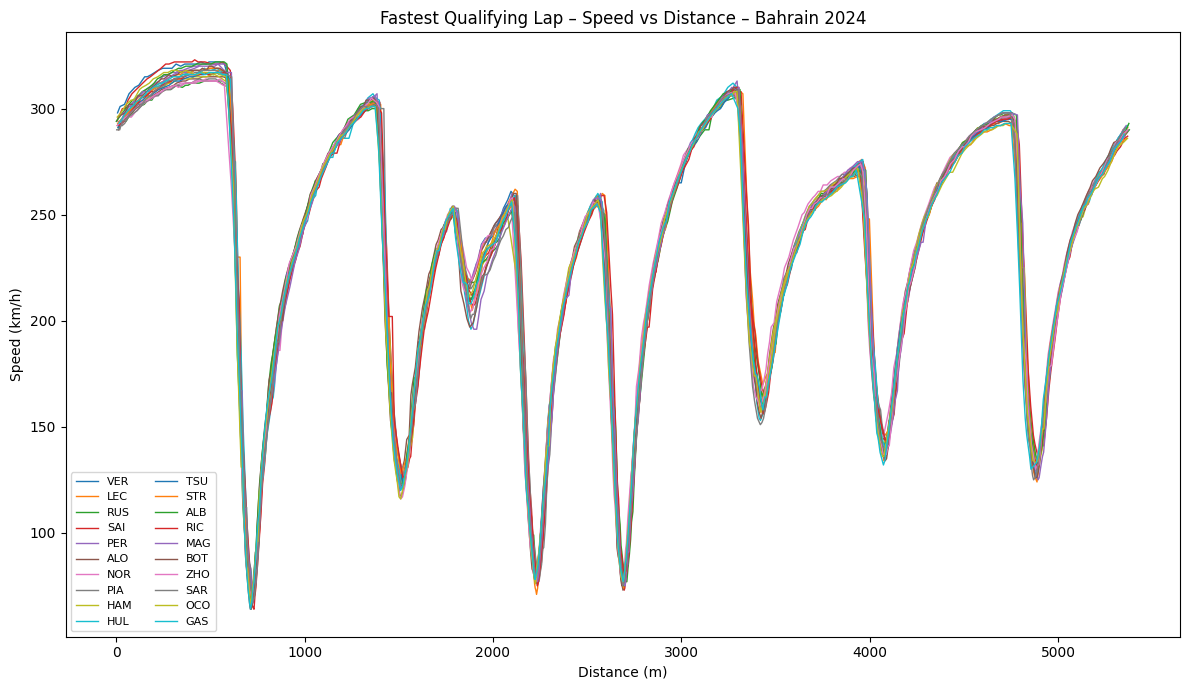

In [17]:
year = 2024
grand_prix = "Bahrain"
target_sessions = ("Q",)  # change to ("R",) for race, etc.

#fastf1.Cache.enable_cache("f1_cache")
session = fastf1.get_session(year, grand_prix, target_sessions[0])
session.load()

# session.drivers returns driver numbers; convert to 3-letter codes
driver_nums: List[int] = session.drivers
drivers: List[str] = [session.get_driver(num)["Abbreviation"] for num in driver_nums]

print(f"Found {len(drivers)} drivers: {drivers}")

# 2) For each driver, fetch telemetry with our helper (only Q), then pick their fastest lap in that session
per_driver_fastest = {}  # driver -> (df_fastest_lap_telemetry, lap_number, lap_time)

for drv in drivers:
    df = collect_driver_telemetry(year, grand_prix, drv, sessions=target_sessions, include_position=False)
    if df.empty:
        print(f"[warn] No telemetry for {drv} in {target_sessions}")
        continue

    # LapTime is attached per sample; get per-lap LapTime (drop NaT), pick min
    lap_times = (
        df[["LapNumber", "LapTime"]]
        .dropna(subset=["LapTime"])
        .drop_duplicates(subset=["LapNumber"])
    )

    if lap_times.empty:
        print(f"[warn] No valid LapTime for {drv}; skipping")
        continue

    fastest_row = lap_times.loc[lap_times["LapTime"].idxmin()]
    fastest_lap_no = int(fastest_row["LapNumber"])

    # Filter telemetry for that lap
    lap_df = df[df["LapNumber"] == fastest_lap_no].copy()
    # Sanity: sort by Distance (in case)
    if "Distance" in lap_df.columns:
        lap_df = lap_df.sort_values("Distance")
    else:
        # add_distance should have created it, but just in case:
        print(f"[warn] {drv} fastest lap missing Distance; skipping")
        continue

    per_driver_fastest[drv] = (lap_df, fastest_lap_no, fastest_row["LapTime"])

# 3) Plot all drivers’ fastest-lap Speed vs Distance on a single chart
plt.figure(figsize=(12, 7))
for drv, (lap_df, lap_no, lap_time) in per_driver_fastest.items():
    # Some samples can have NaNs; drop those for plotting
    dd = lap_df.dropna(subset=["Distance", "Speed"])
    if dd.empty:
        continue
    plt.plot(dd["Distance"], dd["Speed"], linewidth=1, label=drv)

plt.title(f"Fastest Qualifying Lap – Speed vs Distance – {grand_prix} {year}")
plt.xlabel("Distance (m)")
plt.ylabel("Speed (km/h)")
# With 20 drivers, a full legend can clutter; you can toggle the line below on/off:
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

Apex candidates (top curvature peaks):
      s_m     kappa
0   670.0  0.000186
1   734.0  0.048957
2   824.0  0.028829
3   944.0  0.008706
4  1514.0  0.028106

Corner segments (coarse):
   start_m  end_m
0    690.0  774.0
1    804.0  804.0
2    808.0  856.0
3    860.0  860.0
4    864.0  864.0


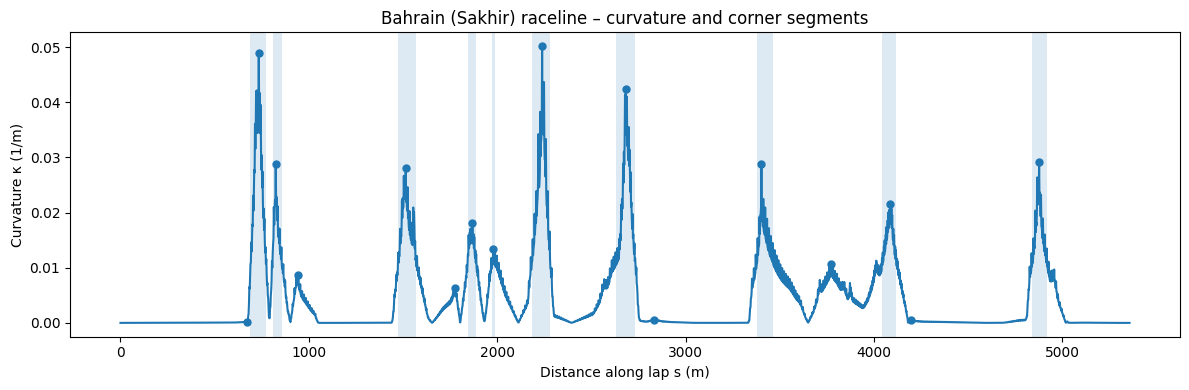

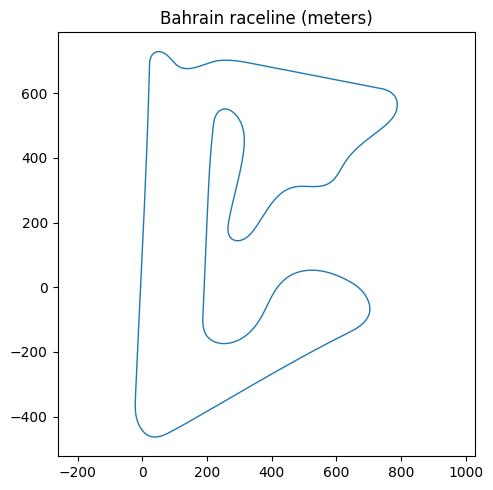

In [18]:

RAW_URL = "https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Sakhir.csv"

def load_raceline_csv(raw_url: str) -> pd.DataFrame:
    """
    Load raceline CSV and return float columns x_m, y_m.
    Handles comma or semicolon delimiters and coerces numeric types.
    """
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()

    # Try to auto-detect delimiter (comma or semicolon) & header using the Python engine
    df = pd.read_csv(
        io.StringIO(r.text),
        comment="#",
        sep=None,              # auto-detect delimiter
        engine="python"
    )

    # If there are extra columns, pick the first two numeric-like columns
    # Try common header names first
    possible_x = [c for c in df.columns if str(c).lower() in ("x_m", "x", "xm")]
    possible_y = [c for c in df.columns if str(c).lower() in ("y_m", "y", "ym")]

    if possible_x and possible_y:
        x_col, y_col = possible_x[0], possible_y[0]
    else:
        # Otherwise, take first two columns
        x_col, y_col = df.columns[:2]

    # Coerce to numeric (handles numbers that came in as strings)
    df = df[[x_col, y_col]].copy()
    df.columns = ["x_m", "y_m"]
    df["x_m"] = pd.to_numeric(df["x_m"], errors="coerce")
    df["y_m"] = pd.to_numeric(df["y_m"], errors="coerce")

    # Drop any non-numeric rows that failed coercion
    df = df.dropna(subset=["x_m", "y_m"]).reset_index(drop=True)

    # Ensure it's a closed loop (optional but nice for derivatives)
    if (df.iloc[0] != df.iloc[-1]).any():
        df = pd.concat([df, df.iloc[[0]]], ignore_index=True)

    return df

def arc_length(df: pd.DataFrame) -> pd.Series:
    dx = np.diff(df.x_m, prepend=df.x_m.iloc[0])
    dy = np.diff(df.y_m, prepend=df.y_m.iloc[0])
    return pd.Series(np.cumsum(np.hypot(dx, dy)), name="s_m")

def curvature_from_xy(x: np.ndarray, y: np.ndarray, s: np.ndarray) -> np.ndarray:
    # central differences on arc-length parameter s
    # guard against non-strictly-increasing s
    s = np.maximum.accumulate(s + 1e-12*np.arange(len(s)))
    x_s  = np.gradient(x, s)
    y_s  = np.gradient(y, s)
    x_ss = np.gradient(x_s, s)
    y_ss = np.gradient(y_s, s)
    kappa = np.abs(x_s * y_ss - y_s * x_ss) / np.power(x_s**2 + y_s**2, 1.5)
    # numerical safety
    kappa = np.nan_to_num(kappa, nan=0.0, posinf=0.0, neginf=0.0)
    return kappa

def resample_equal_arclength(df: pd.DataFrame, step_m: float = 2.0) -> pd.DataFrame:
    """Resample polyline to ~constant spacing along s, improving curvature stability."""
    s = arc_length(df).values
    s_new = np.arange(0, s[-1], step_m)
    # linear interpolation
    x_new = np.interp(s_new, s, df.x_m.values)
    y_new = np.interp(s_new, s, df.y_m.values)
    out = pd.DataFrame({"s_m": s_new, "x_m": x_new, "y_m": y_new})
    # close loop exactly
    if (out.iloc[0][["x_m","y_m"]].values != out.iloc[-1][["x_m","y_m"]].values).any():
        out = pd.concat([out, out.iloc[[0]]], ignore_index=True)
        out.loc[out.index[-1], "s_m"] = out["s_m"].iloc[-2] + step_m
    return out

def build_corner_segments(curv: pd.Series, s: pd.Series, prominence=1e-4, width=8, thr_quantile=0.85):
    """Return (peaks_df, segments_df) from curvature signal."""
    # Peaks as candidate apexes
    peaks, props = find_peaks(curv.values, prominence=prominence, width=width)
    peaks_df = pd.DataFrame({"s_m": s.iloc[peaks].values, "kappa": curv.iloc[peaks].values})

    # Threshold to create contiguous 'corner' regions
    thr = np.quantile(curv, thr_quantile)
    is_corner = curv > thr
    segments = []
    run = None
    for si, flag in zip(s.values, is_corner.values):
        if flag and run is None:
            run = {"start_m": si}
        if not flag and run is not None:
            run["end_m"] = prev_s
            segments.append(run); run = None
        prev_s = si
    if run is not None:
        run["end_m"] = s.values[-1]
        segments.append(run)
    seg_df = pd.DataFrame(segments)
    return peaks_df, seg_df

# --- main usage ---
raceline = load_raceline_csv(RAW_URL)               # (x_m, y_m) in meters
rl_eq = resample_equal_arclength(raceline, 2.0)     # ~2 m spacing for stable κ(s)

kappa = curvature_from_xy(rl_eq.x_m.values, rl_eq.y_m.values, rl_eq.s_m.values)
rl_eq["kappa"] = kappa

peaks_df, seg_df = build_corner_segments(rl_eq["kappa"], rl_eq["s_m"],
                                         prominence=1e-4, width=8, thr_quantile=0.85)

print("Apex candidates (top curvature peaks):")
print(peaks_df.head())
print("\nCorner segments (coarse):")
print(seg_df.head())

# Quick plots
plt.figure(figsize=(12,4))
plt.plot(rl_eq["s_m"], rl_eq["kappa"])
plt.scatter(peaks_df["s_m"], peaks_df["kappa"], s=25)
for _, row in seg_df.iterrows():
    plt.axvspan(row.start_m, row.end_m, alpha=0.15)
plt.xlabel("Distance along lap s (m)"); plt.ylabel("Curvature κ (1/m)")
plt.title("Bahrain (Sakhir) raceline – curvature and corner segments")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.plot(rl_eq["x_m"], rl_eq["y_m"], lw=1)
plt.axis("equal"); plt.title("Bahrain raceline (meters)")
plt.tight_layout(); plt.show()

In [19]:
def aggregate_telemetry_by_segments(telemetry_df: pd.DataFrame, segments_df: pd.DataFrame, 
                                   segment_type: str = "corner") -> pd.DataFrame:
    """
    Aggregate telemetry data by track segments (corners/straights).
    
    Args:
        telemetry_df: DataFrame with telemetry data including 'Distance' column
        segments_df: DataFrame with segment definitions (start_m, end_m columns)
        segment_type: Type of segments for labeling ("corner", "straight", etc.)
    
    Returns:
        DataFrame with aggregated statistics per segment
    """
    aggregated_data = []
    
    for idx, segment in segments_df.iterrows():
        start_m = segment['start_m']
        end_m = segment['end_m']
        
        # Filter telemetry data for this segment
        segment_mask = (telemetry_df['Distance'] >= start_m) & (telemetry_df['Distance'] <= end_m)
        segment_data = telemetry_df[segment_mask]
        
        if segment_data.empty:
            continue
            
        # Calculate aggregated statistics
        stats = {
            'segment_id': idx,
            'segment_type': segment_type,
            'start_m': start_m,
            'end_m': end_m,
            'length_m': end_m - start_m,
            'sample_count': len(segment_data),
            'avg_speed_kmh': segment_data['Speed'].mean(),
            'max_speed_kmh': segment_data['Speed'].max(),
            'min_speed_kmh': segment_data['Speed'].min(),
            'avg_throttle': segment_data['Throttle'].mean(),
            'avg_brake': segment_data['Brake'].mean(),
            'brake_percentage': (segment_data['Brake'] == True).mean() * 100,
            'avg_rpm': segment_data['RPM'].mean(),
            'max_rpm': segment_data['RPM'].max(),
            'avg_gear': segment_data['nGear'].mean(),
            'drs_usage': (segment_data['DRS'] == True).mean() * 100,
        }
        
        # Add lap-specific info if available
        if 'LapNumber' in segment_data.columns:
            stats['lap_numbers'] = segment_data['LapNumber'].unique().tolist()
            stats['lap_count'] = len(segment_data['LapNumber'].unique())
        
        aggregated_data.append(stats)
    
    return pd.DataFrame(aggregated_data)

# Get VER's race telemetry data
print("Loading VER's race telemetry data...")
ver_race_data = collect_driver_telemetry(2024, "Bahrain", "VER", sessions=("R",), include_position=True)

print(f"Loaded {len(ver_race_data)} telemetry samples for VER")
print(f"Lap range: {ver_race_data['LapNumber'].min()} to {ver_race_data['LapNumber'].max()}")
print(f"Distance range: {ver_race_data['Distance'].min():.1f}m to {ver_race_data['Distance'].max():.1f}m")

# Aggregate by corner segments
print("\nAggregating telemetry by corner segments...")
corner_aggregated = aggregate_telemetry_by_segments(ver_race_data, seg_df, "corner")

print(f"\nCorner segments analysis:")
print(f"Found {len(corner_aggregated)} corner segments")
print(corner_aggregated[['segment_id', 'start_m', 'end_m', 'length_m', 'avg_speed_kmh', 'avg_throttle', 'brake_percentage']].round(2))


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading VER's race telemetry data...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
/Users/leoqian/CDS/F1ML2/venv/lib/python3.11/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


Loaded 20526 telemetry samples for VER
Lap range: 1 to 57
Distance range: 0.0m to 5390.7m

Aggregating telemetry by corner segments...

Corner segments analysis:
Found 10 corner segments
   segment_id  start_m   end_m  length_m  avg_speed_kmh  avg_throttle  \
0           0    690.0   774.0      84.0          81.28         28.47   
1           2    808.0   856.0      48.0         163.06         87.49   
2           5   1474.0  1570.0      96.0         127.27         29.11   
3           8   1842.0  1888.0      46.0         187.30         32.63   
4          10   1974.0  1988.0      14.0         204.75         72.67   
5          15   2184.0  2280.0      96.0          89.03         25.32   
6          19   2628.0  2732.0     104.0          93.32         18.65   
7          21   3376.0  3466.0      90.0         159.75         36.10   
8          30   4042.0  4118.0      76.0         138.53         33.17   
9          34   4840.0  4916.0      76.0         125.73         29.96   

   brake_

In [ ]:
# Additional analysis: Create straight segments between corners
def create_straight_segments(corner_segments_df: pd.DataFrame, track_length: float) -> pd.DataFrame:
    """identify straight segments between corner segments."""
    straight_segments = []
    
    # Sort corners by start position
    corners_sorted = corner_segments_df.sort_values('start_m').reset_index(drop=True)
    
    # Add straight before first corner
    if corners_sorted.iloc[0]['start_m'] > 0:
        straight_segments.append({
            'start_m': 0,
            'end_m': corners_sorted.iloc[0]['start_m'],
            'segment_type': 'straight'
        })
    
    # Add straights between corners
    for i in range(len(corners_sorted) - 1):
        current_end = corners_sorted.iloc[i]['end_m']
        next_start = corners_sorted.iloc[i + 1]['start_m']
        
        if next_start > current_end:
            straight_segments.append({
                'start_m': current_end,
                'end_m': next_start,
                'segment_type': 'straight'
            })
    
    # Add straight after last corner
    last_corner_end = corners_sorted.iloc[-1]['end_m']
    if last_corner_end < track_length:
        straight_segments.append({
            'start_m': last_corner_end,
            'end_m': track_length,
            'segment_type': 'straight'
        })
    
    return pd.DataFrame(straight_segments)

# Create straight segments
track_length = ver_race_data['Distance'].max()
straight_segments = create_straight_segments(seg_df, track_length)

print(f"Created {len(straight_segments)} straight segments")
print(straight_segments)

# Aggregate telemetry for straight segments
straight_aggregated = aggregate_telemetry_by_segments(ver_race_data, straight_segments, "straight")

print(f"\nStraight segments analysis:")
print(f"Found {len(straight_aggregated)} straight segments")
print(straight_aggregated[['segment_id', 'start_m', 'end_m', 'length_m', 'avg_speed_kmh', 'avg_throttle', 'brake_percentage']].round(2))

# Combine all segments for comprehensive analysis
all_segments = pd.concat([
    corner_aggregated.assign(segment_type='corner'),
    straight_aggregated.assign(segment_type='straight')
]).sort_values('start_m').reset_index(drop=True)

print(f"\nComplete track analysis:")
print(f"Total segments: {len(all_segments)} ({len(corner_aggregated)} corners, {len(straight_aggregated)} straights)")
print(f"Track coverage: {all_segments['length_m'].sum():.1f}m out of {track_length:.1f}m total")


Created 38 straight segments
    start_m    end_m segment_type
0       0.0   690.00     straight
1     774.0   804.00     straight
2     804.0   808.00     straight
3     856.0   860.00     straight
4     860.0   864.00     straight
5     864.0  1474.00     straight
6    1570.0  1574.00     straight
7    1574.0  1838.00     straight
8    1838.0  1842.00     straight
9    1888.0  1968.00     straight
10   1968.0  1974.00     straight
11   1988.0  1994.00     straight
12   1994.0  1998.00     straight
13   1998.0  2008.00     straight
14   2008.0  2178.00     straight
15   2178.0  2184.00     straight
16   2280.0  2608.00     straight
17   2608.0  2618.00     straight
18   2618.0  2622.00     straight
19   2622.0  2628.00     straight
20   2732.0  3372.00     straight
21   3372.0  3376.00     straight
22   3466.0  3472.00     straight
23   3472.0  3482.00     straight
24   3482.0  3492.00     straight
25   3492.0  3502.00     straight
26   3502.0  3772.00     straight
27   3772.0  4012.0

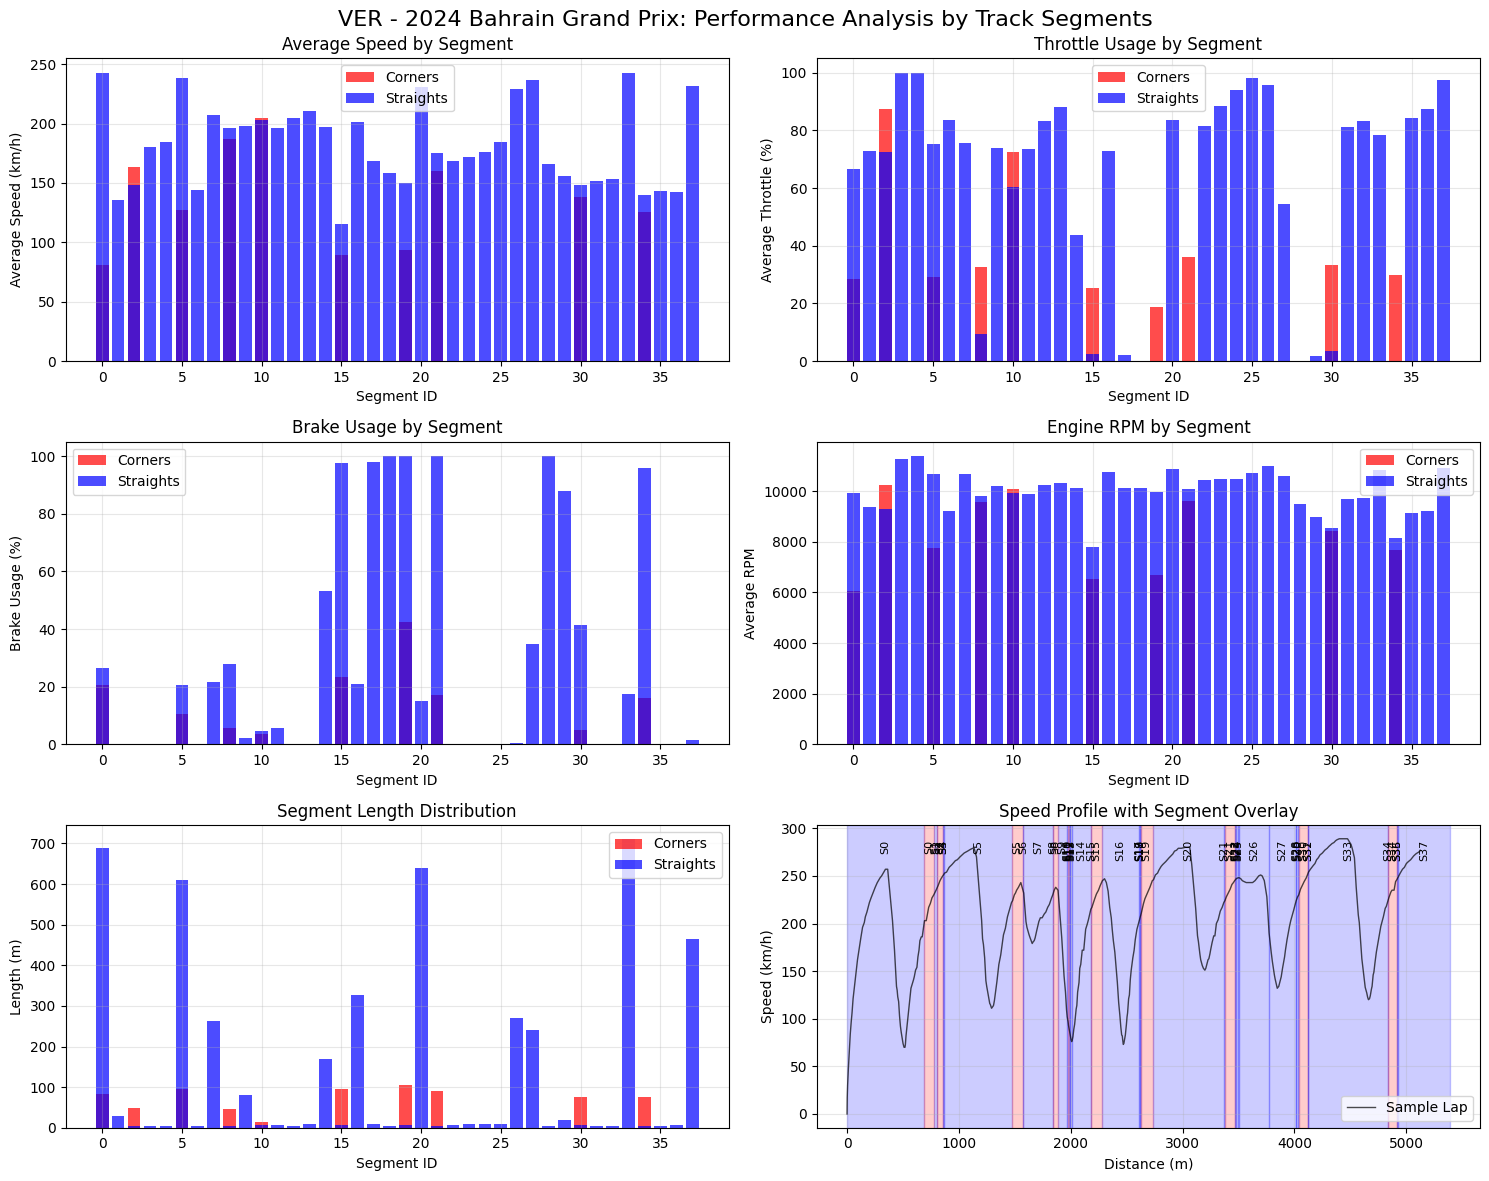


SUMMARY: VER's Performance Analysis by Track Segments

CORNER SEGMENTS (10 segments):
  Average speed: 137.0 km/h
  Average throttle: 39.4%
  Average brake usage: 14.4%
  Average RPM: 8266

STRAIGHT SEGMENTS (38 segments):
  Average speed: 182.3 km/h
  Average throttle: 59.8%
  Average brake usage: 28.2%
  Average RPM: 10008

TRACK COVERAGE:
  Total track length: 5390.7m
  Analyzed segments: 5390.7m (100.0%)
  Corner segments: 730.0m (13.5%)
  Straight segments: 4660.7m (86.5%)


In [21]:
# Comprehensive visualization of VER's performance by track segments
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("VER - 2024 Bahrain Grand Prix: Performance Analysis by Track Segments", fontsize=16)

# Color mapping for segment types
colors = {'corner': 'red', 'straight': 'blue'}

# 1. Average Speed by Segment
ax1 = axes[0, 0]
for segment_type in ['corner', 'straight']:
    data = all_segments[all_segments['segment_type'] == segment_type]
    ax1.bar(data['segment_id'], data['avg_speed_kmh'], 
            color=colors[segment_type], alpha=0.7, label=f'{segment_type.title()}s')
ax1.set_xlabel('Segment ID')
ax1.set_ylabel('Average Speed (km/h)')
ax1.set_title('Average Speed by Segment')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Throttle Usage by Segment
ax2 = axes[0, 1]
for segment_type in ['corner', 'straight']:
    data = all_segments[all_segments['segment_type'] == segment_type]
    ax2.bar(data['segment_id'], data['avg_throttle'], 
            color=colors[segment_type], alpha=0.7, label=f'{segment_type.title()}s')
ax2.set_xlabel('Segment ID')
ax2.set_ylabel('Average Throttle (%)')
ax2.set_title('Throttle Usage by Segment')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Brake Usage by Segment
ax3 = axes[1, 0]
for segment_type in ['corner', 'straight']:
    data = all_segments[all_segments['segment_type'] == segment_type]
    ax3.bar(data['segment_id'], data['brake_percentage'], 
            color=colors[segment_type], alpha=0.7, label=f'{segment_type.title()}s')
ax3.set_xlabel('Segment ID')
ax3.set_ylabel('Brake Usage (%)')
ax3.set_title('Brake Usage by Segment')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. RPM by Segment
ax4 = axes[1, 1]
for segment_type in ['corner', 'straight']:
    data = all_segments[all_segments['segment_type'] == segment_type]
    ax4.bar(data['segment_id'], data['avg_rpm'], 
            color=colors[segment_type], alpha=0.7, label=f'{segment_type.title()}s')
ax4.set_xlabel('Segment ID')
ax4.set_ylabel('Average RPM')
ax4.set_title('Engine RPM by Segment')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Segment Length Distribution
ax5 = axes[2, 0]
for segment_type in ['corner', 'straight']:
    data = all_segments[all_segments['segment_type'] == segment_type]
    ax5.bar(data['segment_id'], data['length_m'], 
            color=colors[segment_type], alpha=0.7, label=f'{segment_type.title()}s')
ax5.set_xlabel('Segment ID')
ax5.set_ylabel('Length (m)')
ax5.set_title('Segment Length Distribution')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Speed vs Distance with Segment Overlay
ax6 = axes[2, 1]
# Plot a sample lap for reference
sample_lap = ver_race_data[ver_race_data['LapNumber'] == 1].sort_values('Distance')
ax6.plot(sample_lap['Distance'], sample_lap['Speed'], 'k-', alpha=0.7, linewidth=1, label='Sample Lap')

# Overlay segment boundaries
for _, segment in all_segments.iterrows():
    color = colors[segment['segment_type']]
    ax6.axvspan(segment['start_m'], segment['end_m'], alpha=0.2, color=color)
    # Add segment labels
    mid_point = (segment['start_m'] + segment['end_m']) / 2
    ax6.text(mid_point, ax6.get_ylim()[1] * 0.95, f"S{segment['segment_id']}", 
             ha='center', va='top', fontsize=8, rotation=90)

ax6.set_xlabel('Distance (m)')
ax6.set_ylabel('Speed (km/h)')
ax6.set_title('Speed Profile with Segment Overlay')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("SUMMARY: VER's Performance Analysis by Track Segments")
print("="*60)

print(f"\nCORNER SEGMENTS ({len(corner_aggregated)} segments):")
print(f"  Average speed: {corner_aggregated['avg_speed_kmh'].mean():.1f} km/h")
print(f"  Average throttle: {corner_aggregated['avg_throttle'].mean():.1f}%")
print(f"  Average brake usage: {corner_aggregated['brake_percentage'].mean():.1f}%")
print(f"  Average RPM: {corner_aggregated['avg_rpm'].mean():.0f}")

print(f"\nSTRAIGHT SEGMENTS ({len(straight_aggregated)} segments):")
print(f"  Average speed: {straight_aggregated['avg_speed_kmh'].mean():.1f} km/h")
print(f"  Average throttle: {straight_aggregated['avg_throttle'].mean():.1f}%")
print(f"  Average brake usage: {straight_aggregated['brake_percentage'].mean():.1f}%")
print(f"  Average RPM: {straight_aggregated['avg_rpm'].mean():.0f}")

print(f"\nTRACK COVERAGE:")
print(f"  Total track length: {track_length:.1f}m")
print(f"  Analyzed segments: {all_segments['length_m'].sum():.1f}m ({100*all_segments['length_m'].sum()/track_length:.1f}%)")
print(f"  Corner segments: {corner_aggregated['length_m'].sum():.1f}m ({100*corner_aggregated['length_m'].sum()/track_length:.1f}%)")
print(f"  Straight segments: {straight_aggregated['length_m'].sum():.1f}m ({100*straight_aggregated['length_m'].sum()/track_length:.1f}%)")
